# Import librairies

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import itertools
import os
import sys
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Vérifications d'usage et paramètres du notebook

In [2]:
print(sys.version)
print(os.getcwd())
warnings.filterwarnings("ignore")

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
C:\Users\LUUD7410\Documents\Boulot\Big Data\Rallye Data\CONSO_RESS_TECH


# Déclaration des fonctions

## Fonction de préparation des données du dataset de train et du dataset pour soumission

In [3]:
def dataprep(data, fictest=False):
    infra_capt = pd.get_dummies(data['INFRA_capt'], prefix='INFRA_capt')
    infra_liv = pd.get_dummies(data['INFRA_liv'], prefix='INFRA_liv')
    # infra_dif non significatif
    infra_dif = pd.DataFrame(data.apply ( lambda row : int(row['INFRA_capt'] != row['INFRA_liv']), axis = 1 ), columns = ['INFRA_dif'])
    # Capt et Liv scalées
    cpu_capt_minmax = pd.DataFrame(MinMaxScaler().fit_transform(data[['CPU_capt']]), columns = ['CPU_capt_minmax'])
    ram_capt_minmax = pd.DataFrame(MinMaxScaler().fit_transform(data[['RAM_capt']]), columns = ['RAM_capt_minmax'])
    datastore_capt_minmax = pd.DataFrame(MinMaxScaler().fit_transform(data[['Datastore_capt']]), columns = ['Datastore_capt_minmax'])
    vm_capt_minmax = pd.DataFrame(MinMaxScaler().fit_transform(data[['VM_capt']]), columns = ['VM_capt_minmax'])
    cpu_liv_minmax = pd.DataFrame(MinMaxScaler().fit_transform(data[['CPU_liv']]), columns = ['CPU_liv_minmax'])
    ram_liv_minmax = pd.DataFrame(MinMaxScaler().fit_transform(data[['RAM_liv']]), columns = ['RAM_liv_minmax'])
    datastore_liv_minmax = pd.DataFrame(MinMaxScaler().fit_transform(data[['Datastore_liv']]), columns = ['Datastore_liv_minmax'])
    vm_liv_minmax = pd.DataFrame(MinMaxScaler().fit_transform(data[['VM_liv']]), columns = ['VM_liv_minmax'])
    
    # soustraction entre les capt et liv en valeur absolue, puis valeurs scalées
    cpu_dif = pd.DataFrame(data.apply ( lambda row : abs(row['CPU_capt'] - row['CPU_liv']), axis = 1 ), columns = ['CPU_dif'])
    cpu_dif_minmax = pd.DataFrame(MinMaxScaler().fit_transform(cpu_dif),columns = ['CPU_dif_minmax'])
    ram_dif = pd.DataFrame(data.apply ( lambda row : abs(row['RAM_capt'] - row['RAM_liv']), axis = 1 ), columns = ['RAM_dif'])
    ram_dif_minmax = pd.DataFrame(MinMaxScaler().fit_transform(ram_dif),columns = ['RAM_dif_minmax'])
    datastore_dif = pd.DataFrame(data.apply ( lambda row : abs(row['Datastore_capt'] - row['Datastore_liv']), axis = 1 ), columns = ['Datastore_dif'])
    datastore_dif_minmax = pd.DataFrame(MinMaxScaler().fit_transform(datastore_dif),columns = ['Datastore_dif_minmax'])
    vm_dif = pd.DataFrame(data.apply ( lambda row : abs(row['VM_capt'] - row['VM_liv']), axis = 1 ), columns = ['VM_dif'])
    vm_dif_minmax = pd.DataFrame(MinMaxScaler().fit_transform(vm_dif),columns = ['VM_dif_minmax'])
    
    # coefficient multiplicateur entre les capt et les liv. Si une valeur à 0 elle est remplacée par 1 
    # pour éviter les divisions par 0 et les résultats à 0
    # puis valeurs scalées
    cpu_coefmul = pd.DataFrame(data.apply (lambda row : ((max(row['CPU_capt'],row['CPU_liv'])) if (max(row['CPU_capt'],row['CPU_liv'])) != 0 else 1) / ((min(row['CPU_capt'],row['CPU_liv'])) if (min(row['CPU_capt'],row['CPU_liv'])) != 0 else 1),axis = 1 ), columns = ['CPU_coefmul'])
    cpu_coefmul_minmax = pd.DataFrame(MinMaxScaler().fit_transform(cpu_coefmul),columns = ['CPU_coefmul_minmax'])
    ram_coefmul = pd.DataFrame(data.apply (lambda row : ((max(row['RAM_capt'],row['RAM_liv'])) if (max(row['RAM_capt'],row['RAM_liv'])) != 0 else 1) / ((min(row['RAM_capt'],row['RAM_liv'])) if (min(row['RAM_capt'],row['RAM_liv'])) != 0 else 1),axis = 1 ), columns = ['RAM_coefmul'])
    ram_coefmul_minmax = pd.DataFrame(MinMaxScaler().fit_transform(ram_coefmul),columns = ['RAM_coefmul_minmax'])
    datastore_coefmul = pd.DataFrame(data.apply (lambda row : ((max(row['Datastore_capt'],row['Datastore_liv'])) if (max(row['Datastore_capt'],row['Datastore_liv'])) != 0 else 1) / ((min(row['Datastore_capt'],row['Datastore_liv'])) if (min(row['Datastore_capt'],row['Datastore_liv'])) != 0 else 1),axis = 1 ), columns = ['Datastore_coefmul'])
    datastore_coefmul_minmax = pd.DataFrame(MinMaxScaler().fit_transform(datastore_coefmul),columns = ['Datastore_coefmul_minmax'])
    vm_coefmul = pd.DataFrame(data.apply (lambda row : ((max(row['VM_capt'],row['VM_liv'])) if (max(row['VM_capt'],row['VM_liv'])) != 0 else 1) / ((min(row['VM_capt'],row['VM_liv'])) if (min(row['VM_capt'],row['VM_liv'])) != 0 else 1),axis = 1 ), columns = ['VM_coefmul'])
    vm_coefmul_minmax = pd.DataFrame(MinMaxScaler().fit_transform(vm_coefmul),columns = ['VM_coefmul_minmax'])
   
    # coefficient multiplicateur corrigés : si capt à zéro alors coef mul = 1
    # peut-être moins biaisé que le coef multiplicateur du dessus
    cpu_coefmulcorr = pd.DataFrame(data.apply (lambda row : 1 if (row['CPU_capt'] == 0) else (max(row['CPU_capt'],row['CPU_liv'])) / (min(row['CPU_capt'],row['CPU_liv'])) ,axis = 1 ), columns = ['CPU_coefmulcorr'])
    ram_coefmulcorr = pd.DataFrame(data.apply (lambda row : 1 if (row['RAM_capt'] == 0) else (max(row['RAM_capt'],row['RAM_liv'])) / (min(row['RAM_capt'],row['RAM_liv'])) ,axis = 1 ), columns = ['RAM_coefmulcorr'])
    datastore_coefmulcorr = pd.DataFrame(data.apply (lambda row : 1 if (row['Datastore_capt'] == 0) else (max(row['Datastore_capt'],row['Datastore_liv'])) / (min(row['Datastore_capt'],row['Datastore_liv'])) ,axis = 1 ), columns = ['Datastore_coefmulcorr'])
    vm_coefmulcorr = pd.DataFrame(data.apply (lambda row : 1 if (row['VM_capt'] == 0) else (max(row['VM_capt'],row['VM_liv'])) / (min(row['VM_capt'],row['VM_liv'])) ,axis = 1 ), columns = ['VM_coefmulcorr'])
    
    # booleen 4 colonnes capt à 0
    capt_4zero = pd.DataFrame(data.apply ( lambda row : 1 if (row['CPU_capt']+row['RAM_capt']+row['Datastore_capt']+row['VM_capt'])==0 else 0, axis = 1 ), columns = ['capt_4zero'])
    # booleen 3 colonnes capt cpu,ram,datastore à 0 (pour vm peu importe que ce soit 0 ou non)
    capt_3premzero = pd.DataFrame(data.apply ( lambda row : 1 if (row['CPU_capt']+row['RAM_capt']+row['Datastore_capt'])==0 else 0, axis = 1 ), columns = ['capt_3premzero'])
    
    # sommes des diff cpu+ram, cpu+ram+datastore, cpu+ram+datastore+vm, datastore+vm
    # à partir des valeurs scalées
    somdif_cpuram = pd.DataFrame((cpu_dif_minmax.CPU_dif_minmax+ram_dif_minmax.RAM_dif_minmax),columns = ['Somdif_cpuram'])
    somdif_cpuramdatastore = pd.DataFrame((somdif_cpuram.Somdif_cpuram+datastore_dif_minmax.Datastore_dif_minmax),columns = ['Somdif_cpuramdatastore'])
    somdif_cpuramdatastorevm = pd.DataFrame((somdif_cpuramdatastore.Somdif_cpuramdatastore+vm_dif_minmax.VM_dif_minmax),columns = ['Somdif_cpuramdatastorevm'])
    somdif_datastorevm = pd.DataFrame((datastore_dif_minmax.Datastore_dif_minmax+vm_dif_minmax.VM_dif_minmax),columns = ['Somdif_datastorevm'])
    
    #somme des diff cpu+ram à partir des valeurs brutes
    somdif_cpuramreel = pd.DataFrame((cpu_dif.CPU_dif+ram_dif.RAM_dif),columns = ['Somdif_cpuramreel'])
    
    # multiplication des coef mulplicateurs CPU et RAM
    mul_coefmul_cpu_ram = pd.DataFrame((cpu_coefmul_minmax.CPU_coefmul_minmax*ram_coefmul_minmax.RAM_coefmul_minmax),columns = ['Mul_coefmul_cpu_ram'])
    
    # ratio plutôt que coefmul
    # probablement le même effet que coefmul
    cpu_ratio = pd.DataFrame(data.apply (lambda row : ((min(row['CPU_capt'],row['CPU_liv'])) if (min(row['CPU_capt'],row['CPU_liv'])) != 0 else 1) / ((max(row['CPU_capt'],row['CPU_liv'])) if (max(row['CPU_capt'],row['CPU_liv'])) != 0 else 1),axis = 1 ), columns = ['CPU_ratio'])
    ram_ratio = pd.DataFrame(data.apply (lambda row : ((min(row['RAM_capt'],row['RAM_liv'])) if (min(row['RAM_capt'],row['RAM_liv'])) != 0 else 1) / ((max(row['RAM_capt'],row['RAM_liv'])) if (max(row['RAM_capt'],row['RAM_liv'])) != 0 else 1),axis = 1 ), columns = ['RAM_ratio'])
    datastore_ratio = pd.DataFrame(data.apply (lambda row : ((min(row['Datastore_capt'],row['Datastore_liv'])) if (min(row['Datastore_capt'],row['Datastore_liv'])) != 0 else 1) / ((max(row['Datastore_capt'],row['Datastore_liv'])) if (max(row['Datastore_capt'],row['Datastore_liv'])) != 0 else 1),axis = 1 ), columns = ['Datastore_ratio'])
    vm_ratio = pd.DataFrame(data.apply (lambda row : ((min(row['VM_capt'],row['VM_liv'])) if (min(row['VM_capt'],row['VM_liv'])) != 0 else 1) / ((max(row['VM_capt'],row['VM_liv'])) if (max(row['VM_capt'],row['VM_liv'])) != 0 else 1),axis = 1 ), columns = ['VM_ratio'])
    
    # moyenne des coef mult de CPU et RAM
    moyenne_coefmulCPURAM = pd.DataFrame((cpu_coefmul_minmax.CPU_coefmul_minmax+ram_coefmul_minmax.RAM_coefmul_minmax)/2,columns = ['Moy_coefmul_cpu_ram'])
     
    # coef mul CPU et RAM < 2 - valeurs = 2 ou 1 ou 0 (2 en dessous de 2, ou 1 en dessous de 2 ou aucun en dessous de 2)
    # 2 est une valeur arbitraire mais qui semble pas si mal
    coefmulinf2CPU = pd.DataFrame(cpu_coefmul.apply (lambda row : 1 if (row['CPU_coefmul'] < 2) else 0,axis = 1),columns = ['Coefmulinf2CPU'])
    coefmulinf2RAM = pd.DataFrame(ram_coefmul.apply (lambda row : 1 if (row['RAM_coefmul'] < 2) else 0,axis = 1),columns = ['Coefmulinf2RAM'])                              
    coefmulinf2CPURAM = pd.DataFrame(coefmulinf2CPU.Coefmulinf2CPU+coefmulinf2RAM.Coefmulinf2RAM, columns = ['Coefmulinf2CPURAM'])
                                  
    # perfect diff : diff CPU + diff RAM = 0 - valeurs = 1 ou 0
    perfectdifCPURAM = pd.DataFrame(cpu_dif.CPU_dif + ram_dif.RAM_dif,columns = ['PerfectdifCPURAM_somme'])
    perfectdifCPURAM['PerfectdifCPURAM'] = pd.DataFrame(perfectdifCPURAM.apply (lambda row : 1 if row.PerfectdifCPURAM_somme == 0 else 0,axis = 1))
    del perfectdifCPURAM['PerfectdifCPURAM_somme']
    
    # Nbre de diff perfect : de 0 à 4
    perfect_dif = pd.DataFrame(cpu_dif.apply (lambda row: 1 if row.CPU_dif == 0 else 0, axis = 1),columns = ['perfect_dif_CPU'])
    perfect_dif['perfect_dif_RAM'] = pd.DataFrame(ram_dif.apply (lambda row: 1 if row.RAM_dif == 0 else 0, axis = 1))
    perfect_dif['perfect_dif_Datastore'] = pd.DataFrame(datastore_dif.apply (lambda row: 1 if row.Datastore_dif == 0 else 0, axis = 1))
    perfect_dif['perfect_dif_VM'] = pd.DataFrame(vm_dif.apply (lambda row: 1 if row.VM_dif == 0 else 0, axis = 1))
    perfect_dif['Nb_perfect_dif'] = perfect_dif.perfect_dif_CPU + perfect_dif.perfect_dif_RAM + perfect_dif.perfect_dif_Datastore +perfect_dif.perfect_dif_VM
        
    # 4 zéros + dif ram > 100 + dif cpu > 100
    # 100 est une valeur arbitraire
    # variable pas top
    seuilCPURAM4zeroMauv = pd.DataFrame(cpu_dif.apply (lambda row : 1 if (row['CPU_dif'] > 100) else 0, axis = 1), columns = ['Seuil_cpu'])
    seuilCPURAM4zeroMauv['Seuil_ram'] = pd.DataFrame(ram_dif.apply (lambda row : 1 if (row['RAM_dif'] > 100) else 0, axis = 1))
    seuilCPURAM4zeroMauv['Seuil_4zero'] = pd.DataFrame(capt_4zero.apply (lambda row : 1 if (row['capt_4zero'] == 1) else 0, axis = 1))
    seuilCPURAM4zeroMauv['Seuildif_CPURAMZero'] = pd.DataFrame(seuilCPURAM4zeroMauv.apply (lambda row : 1 if (row['Seuil_cpu']+row['Seuil_ram']+row['Seuil_4zero']==3) else 0, axis = 1))
    del seuilCPURAM4zeroMauv['Seuildif_CPURAMZero']
    del seuilCPURAM4zeroMauv['Seuil_4zero']
    
    # fort coef (ram et cpu >= 2) mais dif ram / cpu < 50 ? bon ou moyen
    # valeurs 2 et 50 sont arbitraires
    essai = pd.DataFrame(cpu_dif.apply (lambda row : 1 if (row['CPU_dif'] < 50) else 0, axis = 1), columns = ['diffCPUinf50'])
    essai['diffRAMinf50'] = pd.DataFrame(ram_dif.apply (lambda row : 1 if (row['RAM_dif'] < 50) else 0, axis = 1))
    essai['MulCPUsup2'] = pd.DataFrame(cpu_coefmul.apply (lambda row : 1 if (row['CPU_coefmul'] >= 2) else 0,axis = 1))
    essai['MulRAMsup2'] = pd.DataFrame(ram_coefmul.apply (lambda row : 1 if (row['RAM_coefmul'] >= 2) else 0,axis = 1))
    essai['coefsup2difinf50'] = pd.DataFrame(essai.apply (lambda row : 1 if (row['diffCPUinf50']+row['diffRAMinf50']+row['MulCPUsup2']+row['MulRAMsup2']==4) else 0,axis = 1))
    
    ########################################################
    # Ajout des feature ou non aux datasets de train ou test
    ########################################################
    
    #dp = infra_capt.join(infra_liv).join(infra_dif).join(cpu_capt_minmax).join(ram_capt_minmax).join(datastore_capt_minmax)
    #dp = infra_dif.join(cpu_capt_minmax).join(ram_capt_minmax).join(datastore_capt_minmax).join(vm_capt_minmax)
    #dp = cpu_capt_minmax.join(ram_capt_minmax).join(datastore_capt_minmax).join(vm_capt_minmax)
    #dp = dp.join(cpu_liv_minmax).join(ram_liv_minmax).join(datastore_liv_minmax).join(vm_liv_minmax)
    #dp = data['CPU_capt'].to_frame().join(data['RAM_capt']).join(data['Datastore_capt']).join(data['VM_capt'])
    dp = data['CPU_capt'].to_frame().join(data['RAM_capt'])
    #dp = data['CPU_capt'].to_frame()
    #dp = data['CPU_liv'].to_frame().join(data['RAM_liv']).join(data['Datastore_liv']).join(data['VM_liv'])
    #dp = dp.join(data['CPU_liv']).join(data['RAM_liv']).join(data['Datastore_liv']).join(data['VM_liv'])
    dp = dp.join(data['CPU_liv']).join(data['RAM_liv'])
    #dp = cpu_liv_minmax.join(ram_liv_minmax).join(datastore_liv_minmax).join(vm_liv_minmax)
    #dp = dp.join(cpu_dif_minmax).join(ram_dif_minmax).join(datastore_dif_minmax).join(vm_dif_minmax)
    #dp = dp.join(cpu_dif).join(ram_dif).join(datastore_dif).join(vm_dif)
    dp = dp.join(cpu_dif).join(ram_dif)
    #dp = cpu_dif.join(ram_dif)
    #dp = cpu_dif.join(ram_dif).join(datastore_dif).join(vm_dif)
    #dp = dp.join(data['Datastore_capt']).join(data['VM_capt'])
    #dp = dp.join(data['CPU_liv']).join(data['RAM_liv']).join(data['Datastore_liv']).join(data['VM_liv'])
    #dp = dp.join(cpu_coefmul).join(ram_coefmul).join(datastore_coefmul).join(vm_coefmul)
    dp = dp.join(cpu_coefmul).join(ram_coefmul)
    #dp = dp.join(cpu_coefmul)
    #dp = dp.join(datastore_coefmul).join(vm_coefmul)
    #dp = dp.join(datastore_coefmul)
    #dp = dp.join(cpu_coefmul_minmax).join(ram_coefmul_minmax).join(datastore_coefmul_minmax).join(vm_coefmul_minmax)
    #dp = dp.join(capt_4zero).join(capt_3premzero)
    dp = dp.join(capt_4zero)
    #dp = dp.join(somdif_cpuram).join(somdif_cpuramdatastore).join(somdif_cpuramdatastorevm).join(somdif_datastorevm)
    #dp = dp.join(somdif_cpuram)
    #dp = dp.join(mul_coefmul_cpu_ram)
    #dp = dp.join(cpu_ratio).join(ram_ratio).join(datastore_ratio).join(vm_ratio)
    #dp = dp.join(moyenne_coefmulCPURAM)
    #dp = dp.join(coefmulinf2CPURAM)
    #dp = dp.join(perfectdifCPURAM)
    #dp = dp.join(seuilCPURAM4zeroMauv)
    #dp = dp.join(essai['coefsup2difinf50'].to_frame())
    #dp = dp.join(essai)
    #dp = dp.join(perfect_dif['Nb_perfect_dif'].to_frame())
    #dp = dp.join(cpu_coefmulcorr).join(ram_coefmulcorr)
    #dp = dp.join(somdif_cpuramreel)
                                                                                           
    # pour le dataset de train on ajoute la colonne 'Score'
    if fictest == False:
        dp = dp.join(data[['Score']])
    return dp

## Fonction d'affichage de matrice de confusion

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        print("")

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## fonction d'exécution des différents modèles

In [5]:
def run_model(model, alg_name):
    # build the model on training data
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_valid)
    # calculate the accuracy score
    accuracy =  accuracy_score(y_valid, y_pred) * 100
    print(alg_name + ' ' + str(accuracy))

## fonction qui prédit sur le jeu de test et écrit le CSV à soumettre 

In [6]:
def prep_fic_soumission(model, alg_name, compar):
    reponse=model.predict(Xtest)
    #print(Xtest.head(12))
    output=pd.DataFrame(df_test[['BASICAT','Date']])
    output['Score']=reponse
    nomfic = 'reponse_'+alg_name+'_'+(datetime.now().strftime("%m%d%H%M%S"))+'.csv'
    #print(nomfic)
    # Ligne suivante à commenter en mode explo, ne sert que pour générer le csv de soumission
    #output.to_csv(nomfic, index=False)
    #print(output['Score'].to_frame())
    namecol = 'Score_'+alg_name
    if compar.empty is False :
        compar = compar.join(output['Score'].to_frame().rename(index=str, columns={"Score": namecol}))
    else:
        compar = output['Score'].to_frame().rename(index=str, columns={"Score": namecol})
    return compar

In [7]:
toutdebut = datetime.now() # pour info temps de traitement total du notebook
# fichier train
fic_train = "train_GRIN.csv"
# fichier test
fic_test = "test_GRIN.csv"

In [8]:
debut = datetime.now()
df_train = pd.read_csv(fic_train, sep=',')
print("Durée chargement fic train = ",str(datetime.now() - debut)," Nombre d'enregistrements = " , len(df_train.index))

# Vérification des types, nombre de valeurs et valeurs manquantes
df_train.info(null_counts=True, verbose=True)

Durée chargement fic train =  0:00:00.015600  Nombre d'enregistrements =  27
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 13 columns):
BASICAT           27 non-null object
Date              27 non-null object
INFRA_capt        27 non-null object
CPU_capt          27 non-null int64
RAM_capt          27 non-null int64
Datastore_capt    27 non-null int64
VM_capt           27 non-null int64
INFRA_liv         27 non-null object
CPU_liv           27 non-null int64
RAM_liv           27 non-null int64
Datastore_liv     27 non-null int64
VM_liv            27 non-null int64
Score             27 non-null object
dtypes: int64(8), object(5)
memory usage: 2.8+ KB


In [9]:
debut = datetime.now()
df_test = pd.read_csv(fic_test, sep=',')
print("Durée chargement fic test = ",str(datetime.now() - debut)," Nombre d'enregistrements = " , len(df_test.index))

# Vérification des types, nombre de valeurs et valeurs manquantes
df_test.info(null_counts=True, verbose=True)

Durée chargement fic test =  0:00:00.015600  Nombre d'enregistrements =  12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 12 columns):
BASICAT           12 non-null object
Date              12 non-null object
INFRA_capt        12 non-null object
CPU_capt          12 non-null int64
RAM_capt          12 non-null int64
Datastore_capt    12 non-null int64
VM_capt           12 non-null int64
INFRA_liv         12 non-null object
CPU_liv           12 non-null int64
RAM_liv           12 non-null int64
Datastore_liv     12 non-null int64
VM_liv            12 non-null int64
dtypes: int64(8), object(4)
memory usage: 1.2+ KB


In [10]:
df_train.head(27)

,BASICAT,Date,INFRA_capt,CPU_capt,RAM_capt,Datastore_capt,VM_capt,INFRA_liv,CPU_liv,RAM_liv,Datastore_liv,VM_liv,Score
0,61W,30/01/2019 16:10,HP1,18,36,1500,9,HP1,6,12,250,3,mauvais
1,BPN,07/02/2019 11:51,SI1,26,212,900,11,HP1SI1,22,108,1125,10,bon
2,CLP,22/11/2018 11:19,Legacy,0,0,0,0,SI1SI2,181,388,6500,54,mauvais
3,CM2,10/10/2018 14:26,SI1,58,132,7120,8,SI2,66,148,1810,9,bon
4,EIP,24/01/2019 10:27,IASIGP2,24,72,700,10,IAS,26,76,1190,10,bon
5,ERB,17/10/2018 15:00,HP1,1140,1900,22800,380,HP1,154,492,4090,66,mauvais
6,ERB,25/01/2019 08:28,HP1,0,0,0,0,HP1,204,480,6330,93,mauvais
7,ERB,17/10/2018 15:00,IT1,960,1600,19200,320,IT1,152,560,3920,63,mauvais
8,ERB,25/01/2019 08:28,IT1,0,0,0,0,IT1,344,776,12010,161,mauvais
9,FHK,08/11/2018 11:19,SI1,6,24,330,6,SI1,2,8,160,2,mauvais


In [11]:
df_test.head(12)

,BASICAT,Date,INFRA_capt,CPU_capt,RAM_capt,Datastore_capt,VM_capt,INFRA_liv,CPU_liv,RAM_liv,Datastore_liv,VM_liv
0,13L,14/03/2019 10:59,Legacy,80,320,1200,20,ISI,80,160,1580,20
1,32X,17/01/2019 14:45,PS1,148,592,9620,74,PS1,116,464,2500,58
2,FIP,20/03/2019 09:21,Legacy,44,150,0,15,ISI,12,40,690,4
3,GER,05/02/2019 18:00,Legacy,144,576,5040,36,ISI,144,576,5040,36
4,NA2,06/12/2018 11:09,ZO,0,0,0,0,ZOE,51,124,1140,19
5,SVL,12/04/2019 15:42,HP1,0,0,0,0,HP1,9,19,205,3
6,55L,14/03/2019 10:59,Legacy,8,3,10,20,ISI,80,160,150,20
7,3E3,17/01/2019 14:45,PS1,1,592,9,7,PS1,116,464,250,58
8,PIF,20/03/2019 09:21,Legacy,44,10,0,15,ISI,12,40,69,4
9,RER,05/02/2019 18:00,Legacy,1,57,50,36,ISI,144,5,50,36


In [12]:
#df_train['Score'].unique()

In [13]:
#df_train['INFRA_capt'].unique()

Représentation classe mauvais =  55.56%
Représentation classe moyen =  14.81%
Représentation classe bon =  29.63%


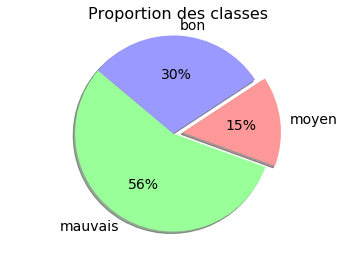

In [14]:
# Vérification de la proportion des classes à prédire
nbmauvais = len(df_train[(df_train['Score'] == 'mauvais')].index)
nbmoyen = len(df_train[(df_train['Score'] == 'moyen')].index)
nbbon = len(df_train[(df_train['Score'] == 'bon')].index)
pctmauvais = nbmauvais / len(df_train.index)
pctmoyen = nbmoyen / len(df_train.index)
pctbon = nbbon / len(df_train.index)
print("Représentation classe mauvais = ", "{0:.2%}".format(pctmauvais))
print("Représentation classe moyen = ", "{0:.2%}".format(pctmoyen))
print("Représentation classe bon = ", "{0:.2%}".format(pctbon))

# Data to plot
labels = 'mauvais', 'moyen', 'bon'
sizes = [pctmauvais,pctmoyen,(1-pctmauvais-pctmoyen)]
colors = ['#99ff99', '#ff9999', '#9999ff']
explode = (0, 0.1,0)  # mise en évidence de la classe minoritaire
titre = 'Proportion des classes'
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.0f%%', shadow=True, startangle=140, textprops={'fontsize': 14})
plt.axis('equal')
plt.title(titre, fontsize=16)
plt.show()

# Préparation des jeux de train et validation

In [15]:
Xtrain = dataprep(df_train,False )
Xtest = dataprep(df_test,True)

X_train, X_valid, y_train, y_valid = train_test_split(
    Xtrain.drop('Score', axis=1), Xtrain['Score'].to_frame(name='Score'),
    test_size=0.3, random_state=42)

In [16]:
Xtrain.sort_values(by = 'Score', ascending = False)

,CPU_capt,RAM_capt,CPU_liv,RAM_liv,CPU_dif,RAM_dif,CPU_coefmul,RAM_coefmul,capt_4zero,Score
24,0,0,8,16,8,16,8.000000,16.000000,1,moyen
23,0,0,9,19,9,19,9.000000,19.000000,1,moyen
22,0,0,8,32,8,32,8.000000,32.000000,1,moyen
18,0,0,2,8,2,8,2.000000,8.000000,1,moyen
0,18,36,6,12,12,24,3.000000,3.000000,0,mauvais
14,2,4,6,20,4,16,3.000000,5.000000,0,mauvais
25,28,56,64,128,36,72,2.285714,2.285714,0,mauvais
20,8,32,16,64,8,32,2.000000,2.000000,0,mauvais
19,176,608,28,56,148,552,6.285714,10.857143,0,mauvais
17,10,36,4,16,6,20,2.500000,2.250000,0,mauvais


In [17]:
Xtrain

,CPU_capt,RAM_capt,CPU_liv,RAM_liv,CPU_dif,RAM_dif,CPU_coefmul,RAM_coefmul,capt_4zero,Score
0,18,36,6,12,12,24,3.000000,3.000000,0,mauvais
1,26,212,22,108,4,104,1.181818,1.962963,0,bon
2,0,0,181,388,181,388,181.000000,388.000000,1,mauvais
3,58,132,66,148,8,16,1.137931,1.121212,0,bon
4,24,72,26,76,2,4,1.083333,1.055556,0,bon
5,1140,1900,154,492,986,1408,7.402597,3.861789,0,mauvais
6,0,0,204,480,204,480,204.000000,480.000000,1,mauvais
7,960,1600,152,560,808,1040,6.315789,2.857143,0,mauvais
8,0,0,344,776,344,776,344.000000,776.000000,1,mauvais
9,6,24,2,8,4,16,3.000000,3.000000,0,mauvais


In [18]:
Xtest

,CPU_capt,RAM_capt,CPU_liv,RAM_liv,CPU_dif,RAM_dif,CPU_coefmul,RAM_coefmul,capt_4zero
0,80,320,80,160,0,160,1.000000,2.000000,0
1,148,592,116,464,32,128,1.275862,1.275862,0
2,44,150,12,40,32,110,3.666667,3.750000,0
3,144,576,144,576,0,0,1.000000,1.000000,0
4,0,0,51,124,51,124,51.000000,124.000000,1
5,0,0,9,19,9,19,9.000000,19.000000,1
6,8,3,80,160,72,157,10.000000,53.333333,0
7,1,592,116,464,115,128,116.000000,1.275862,0
8,44,10,12,40,32,30,3.666667,4.000000,0
9,1,57,144,5,143,52,144.000000,11.400000,0


In [19]:
#nombre de feature
X_train.columns.size

9

In [20]:
#y_train

In [21]:
# vérif du jeu de validation pour la phase de training
X_valid

,CPU_capt,RAM_capt,CPU_liv,RAM_liv,CPU_dif,RAM_dif,CPU_coefmul,RAM_coefmul,capt_4zero
8,0,0,344,776,344,776,344.000000,776.000000,1
13,53,148,17,60,36,88,3.117647,2.466667,0
9,6,24,2,8,4,16,3.000000,3.000000,0
21,46,96,46,96,0,0,1.000000,1.000000,0
0,18,36,6,12,12,24,3.000000,3.000000,0
11,10,36,10,36,0,0,1.000000,1.000000,0
16,0,0,4,16,4,16,4.000000,16.000000,1
17,10,36,4,16,6,20,2.500000,2.250000,0
12,120,480,120,480,0,0,1.000000,1.000000,0


In [22]:
# vérif du jeu de validation pour la phase de training
y_valid

,Score
8,mauvais
13,mauvais
9,mauvais
21,bon
0,mauvais
11,bon
16,bon
17,mauvais
12,bon


# Matrice de corrélation des variables

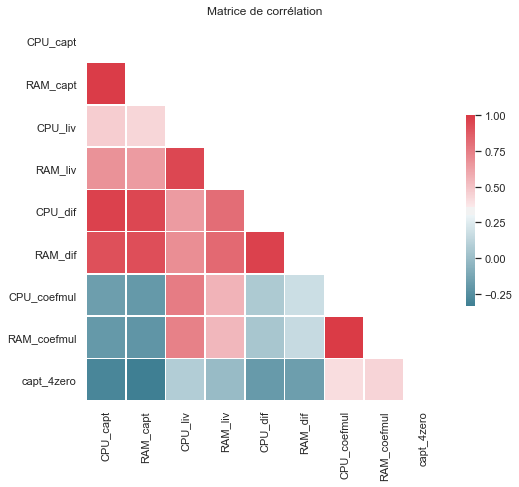

In [23]:
corr = X_train.corr()
sns.set(style="white")

# Generate a mask for the upper triangle, True = absent, False = complet
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax.set_title('Matrice de corrélation')
sns.heatmap(corr, mask=mask, cmap=cmap,linewidths=.5,cbar_kws={"shrink": .5},
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
#plt.savefig("matricecorrelation.jpg")

# Modélisation Random Forest

## Random Forest - Recherche des paramètre / CV

## Modèle Random Forest tuné

In [24]:
# les 4 derniers paramètres dépendent du résultat précédent
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 20, max_depth=4, criterion='gini',n_jobs=-1)

In [25]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [26]:
pred=rfc1.predict(X_valid)

In [27]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_valid,pred))

Accuracy for Random Forest on CV data:  0.8888888888888888


In [28]:
y_valid

,Score
8,mauvais
13,mauvais
9,mauvais
21,bon
0,mauvais
11,bon
16,bon
17,mauvais
12,bon


In [29]:
pred

array(['mauvais', 'mauvais', 'mauvais', 'bon', 'mauvais', 'bon', 'moyen',
       'mauvais', 'bon'], dtype=object)

### Matrice de confusion RF tuné

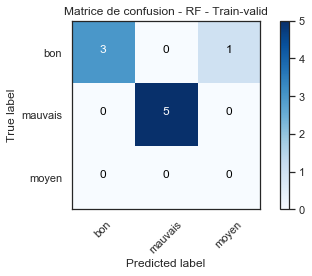

In [30]:
cnf_matrix = confusion_matrix(y_valid, pred)
np.set_printoptions(precision=2)
class_names = ("bon","mauvais","moyen")
# Plot non-normalized confusion matrix
plt.figure()
# Appel à la fonction de génération de matrice de confusion
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Matrice de confusion - RF - Train-valid')

### feature importance RF tuné

In [31]:
rfc1.feature_importances_

array([0.03, 0.06, 0.17, 0.08, 0.05, 0.17, 0.12, 0.26, 0.08])

In [32]:
importances = rfc1.feature_importances_
tabcol = X_valid.columns
b = np.array(tabcol)
S1 = pd.Series(b)
S2 = pd.Series(importances)
df1 = pd.DataFrame(S1, columns=['variables'])
df2 = pd.DataFrame(S2, columns=['importance'])
df = pd.concat([df1, df2], join='outer', axis=1)
result = df.sort_values(['importance'], ascending=[False])
result.head(13)

,variables,importance
7,RAM_coefmul,0.256987
5,RAM_dif,0.172501
2,CPU_liv,0.167588
6,CPU_coefmul,0.116743
8,capt_4zero,0.077190
3,RAM_liv,0.076830
1,RAM_capt,0.057036
4,CPU_dif,0.045336
0,CPU_capt,0.029790


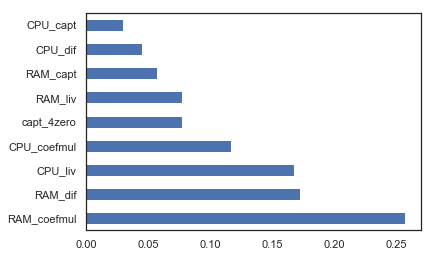

In [33]:
feat_importances = pd.Series(importances, index=X_valid.columns)
feat_importances.nlargest(25).plot(kind='barh')

In [34]:
#Xtest

# XGBOOST

## Boostaroota - librairie pratique et rapide de sélection de variables

In [35]:
# Sélection de variable avec la fonction BoostARoota - à commenter ou décommenter
from boostaroota import BoostARoota
debut = datetime.now()
# Création des dummies si besoin
#x = pd.get_dummies(X_train)
x = X_train
#Specify evaluation metric: use whichever you like as long as recognized by XGBoost
br = BoostARoota(metric='mlogloss')
# Entrainement du modèle avec les variables sélectionnées
br.fit(x, y_train.replace(to_replace=['mauvais', 'moyen', 'bon'], value=[0, 1, 2]))
# Série avec les variables les plus importantes
br.keep_vars_
# Modification du dataframe pour n'inclure que les variables les plus importantes
br.transform(x)
print("Durée sélection variables : ",str(datetime.now() - debut))

Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
Round:  3  iteration:  1
Round:  3  iteration:  2
Round:  3  iteration:  3
Round:  3  iteration:  4
Round:  3  iteration:  5
Round:  3  iteration:  6
Round:  3  iteration:  7
Round:  3  iteration:  8
Round:  3  iteration:  9
Round:  3  iteration:  10
BoostARoota ran successfully! Algorithm went through  3  rounds.
Durée sélection variables :  0:00:01.201192


In [36]:
br.keep_vars_

0       CPU_capt
1        CPU_liv
2        RAM_liv
3        CPU_dif
4    CPU_coefmul
5     capt_4zero
Name: feature, dtype: object

In [37]:
br.transform(x).head()

,CPU_capt,CPU_liv,RAM_liv,CPU_dif,CPU_coefmul,capt_4zero
24,0,8,16,8,8.000000,1
1,26,22,108,4,1.181818,0
4,24,26,76,2,1.083333,0
5,1140,154,492,986,7.402597,0
2,0,181,388,181,181.000000,1


## Hyper paramètres XGBoost

In [38]:
# RECHERCHE HYPER PARAMETRES - à commenter ou décommenter
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 
           'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'multi:softmax', 'num_class': 3}
optimized_GBM = GridSearchCV(XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 6, n_jobs = -1, verbose = 10) 

In [39]:
# RECHERCHE HYPER PARAMETRES - à commenter ou décommenter
cv_params = {'max_depth': [5], 'min_child_weight': [1]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 
           'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'multi:softmax', 'num_class': 3}
optimized_GBM = GridSearchCV(XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 8, n_jobs = -1, verbose = 10) 

In [40]:
# RECHERCHE HYPER PARAMETRES - à commenter ou décommenter
# toujours le min_child_weight = 1 qui est le meilleur quel que soit le max_depth
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 30, 'seed':0, 
           'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'multi:softmax', 'num_class': 3}
optimized_GBM = GridSearchCV(XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 8, n_jobs = -1, verbose = 10) 

In [41]:
debut = datetime.now()
optimized_GBM.fit(X_train, y_train)
print("Durée XGBoost GridSearchCV = ",str(datetime.now() - debut))

Fitting 8 folds for each of 3 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:    6.6s remaining:    1.2s


Durée XGBoost GridSearchCV =  0:00:07.581552


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    7.5s finished


In [42]:
optimized_GBM.best_score_

0.8333333333333334

In [43]:
optimized_GBM.classes_

array(['bon', 'mauvais', 'moyen'], dtype=object)

In [44]:
optimized_GBM.best_params_

{'max_depth': 3, 'min_child_weight': 1}

In [45]:
optimized_GBM.cv_results_

{'mean_fit_time': array([0.02, 0.02, 0.02]),
 'std_fit_time': array([0.01, 0.01, 0.01]),
 'mean_score_time': array([0., 0., 0.]),
 'std_score_time': array([0.01, 0.  , 0.01]),
 'param_max_depth': masked_array(data=[3, 5, 7],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[1, 1, 1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 3, 'min_child_weight': 1},
  {'max_depth': 5, 'min_child_weight': 1},
  {'max_depth': 7, 'min_child_weight': 1}],
 'split0_test_score': array([1., 1., 1.]),
 'split1_test_score': array([0.75, 0.75, 0.75]),
 'split2_test_score': array([0.67, 0.67, 0.67]),
 'split3_test_score': array([1., 1., 1.]),
 'split4_test_score': array([1., 1., 1.]),
 'split5_test_score': array([0., 0., 0.]),
 'split6_test_score': array([1., 1., 1.]),
 'split7_test_score': array([1., 1., 1.]),
 'mean_test_score': array([0.83, 0.

## Paramètres XGBoost

In [46]:
# RECHERCHE PARAMETRES
cv_params = {'learning_rate': [0.1,0.05,0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 1000, 
'seed':0, 'colsample_bytree': 0.8, 'scale_pos_weight' : 1,
             'objective': 'multi:softmax', 'num_class': 3}
optimized_GBM = GridSearchCV(XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 8, n_jobs = -1, verbose = 10) 

In [47]:
debut = datetime.now()
optimized_GBM.fit(X_train, y_train)
print("Durée XGBoost GridSearchCV = ",str(datetime.now() - debut))

Fitting 8 folds for each of 9 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1560s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.9s


Durée XGBoost GridSearchCV =  0:00:03.665977


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    3.4s finished


In [48]:
optimized_GBM.best_score_


0.7777777777777778

In [49]:
optimized_GBM.best_params_

{'learning_rate': 0.01, 'subsample': 0.7}

In [50]:
optimized_GBM.cv_results_

{'mean_fit_time': array([0.16, 0.16, 0.16, 0.17, 0.17, 0.18, 0.25, 0.21, 0.17]),
 'std_fit_time': array([0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.03, 0.02, 0.03]),
 'mean_score_time': array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ]),
 'std_score_time': array([0.  , 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.  ]),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.01, 0.01, 0.01],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[0.7, 0.8, 0.9, 0.7, 0.8, 0.9, 0.7, 0.8, 0.9],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.1, 'subsample': 0.7},
  {'learning_rate': 0.1, 'subsample': 0.8},
  {'learning_rate': 0.1, 'subsample': 0.9},
  {'learning_rate': 0.05, 'subsample': 0

## modèle XGBOOST tuné

In [51]:
modelXGB = xgb.XGBClassifier(n_estimators=20,max_depth=3, min_child_weight=1,
    learning_rate=0.1, subsample=0.7,njobs=-1,verbose=2, colsample_bytree=0.8)
debut = datetime.now()
modelXGB.fit(X_train, y_train)
print("Durée apprentissage XGBoost : ",str(datetime.now() - debut))

Durée apprentissage XGBoost :  0:00:00.015599


In [52]:
pred=modelXGB.predict(X_valid)

In [53]:
print("Accuracy for XGBoost on CV data: ",accuracy_score(y_valid,pred))

Accuracy for XGBoost on CV data:  0.8888888888888888


## Matrice de confusion XGBoost

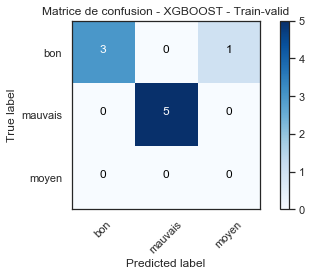

In [54]:
cnf_matrix = confusion_matrix(y_valid, pred)
np.set_printoptions(precision=2)
class_names = ("bon","mauvais","moyen")
# Plot non-normalized confusion matrix
plt.figure()
# Appel à la fonction de génération de matrice de confusion
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Matrice de confusion - XGBOOST - Train-valid')

In [55]:
## Feature importance XGBoost

In [56]:
importances = modelXGB.feature_importances_
tabcol = X_valid.columns
b = np.array(tabcol)
S1 = pd.Series(b)
S2 = pd.Series(importances)
df1 = pd.DataFrame(S1, columns=['variables'])
df2 = pd.DataFrame(S2, columns=['importance'])
df = pd.concat([df1, df2], join='outer', axis=1)
result = df.sort_values(['importance'], ascending=[False])
result.head(20)

,variables,importance
4,CPU_dif,0.188891
6,CPU_coefmul,0.175811
8,capt_4zero,0.128878
7,RAM_coefmul,0.104174
5,RAM_dif,0.098157
0,CPU_capt,0.090828
2,CPU_liv,0.080339
3,RAM_liv,0.071763
1,RAM_capt,0.061158


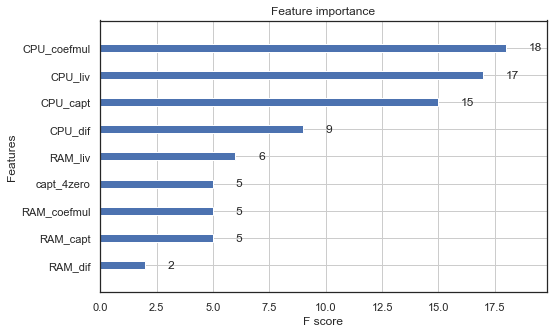

In [57]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(8,5))
plot_importance(modelXGB, height=0.3, ax=ax) 

In [58]:
# Pour les algo suivants non tunés, remplacer les string par des numériques
y_train.replace(to_replace=['mauvais', 'moyen', 'bon'], value=[1, 2, 3])

,Score
24,2
1,3
4,3
5,1
2,1
15,1
22,2
3,3
25,1
23,2


In [59]:
# Dataframe vide qui gardera en stock tous les résultats de tous les algo lancés : les 2 algos tunés + tous le suivants
compar = pd.DataFrame()

In [60]:
# REPONSE RANDOM FOREST
compar = prep_fic_soumission(rfc1, "rf_cv", compar)

In [61]:
# REPONSE XGBOOST
compar = prep_fic_soumission(modelXGB, "xgb_cv",compar)

In [62]:
# Autres algo que RF et XGboost tunés

In [63]:
# ----- Random Forest ---------------
model = RandomForestClassifier(n_estimators=20)
run_model(model, "Random Forest")
compar = prep_fic_soumission(model, "rf",compar)

# ---- Decision Tree -----------
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
run_model(model, "Decision Tree")
compar = prep_fic_soumission(model, "dectree",compar)

# ----- xgboost ------------
model = XGBClassifier()
run_model(model, "XGBoost")
compar = prep_fic_soumission(model, "xgb",compar)

# Résultats quasi constants à 'mauvais'
# ------ SVM Classifier ----------------
#model = SVC()
#run_model(model, "SVM Classifier")
#compar = prep_fic_soumission(model, "svm",compar)

# -------- Nearest Neighbors ----------
model = neighbors.KNeighborsClassifier()
run_model(model, "Nearest Neighbors Classifier")
compar = prep_fic_soumission(model, "knn",compar)

# Résultats quasi constants à 'mauvais'
# ---------- SGD Classifier -----------------
#model = OneVsRestClassifier(SGDClassifier())
#run_model(model, "SGD Classifier")
#compar = prep_fic_soumission(model, "sgd",compar)

# --------- Gaussian Naive Bayes ---------
model = GaussianNB()
run_model(model, "Gaussian Naive Bayes")
compar = prep_fic_soumission(model, "nbay",compar)

# Résultats quasi constants à 'mauvais'
# ----------- Neural network - Multi-layer Perceptron  ------------
#model = MLPClassifier()
#run_model(model, "MLP Neural network ")
#compar = prep_fic_soumission(model, "MLPnn",compar)

# ----------- Régression Logistique  ------------
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=100,multi_class='multinomial',solver = 'lbfgs')
run_model(model, "Régression Logistique ")
compar = prep_fic_soumission(model, "reglog",compar)

# ----------- Light GBM  ------------
from lightgbm import LGBMClassifier

model = LGBMClassifier(min_data=1, min_data_in_bin=1)
run_model(model, "LightGBM ")
compar = prep_fic_soumission(model, "Lgbm",compar)



Random Forest 88.88888888888889
Decision Tree 88.88888888888889
XGBoost 88.88888888888889
Nearest Neighbors Classifier 44.44444444444444
Gaussian Naive Bayes 77.77777777777779
Régression Logistique  88.88888888888889
LightGBM  88.88888888888889


In [64]:
compar.head(12)

,Score_rf_cv,Score_xgb_cv,Score_rf,Score_dectree,Score_xgb,Score_knn,Score_nbay,Score_reglog,Score_Lgbm
0,bon,bon,bon,bon,bon,bon,bon,mauvais,bon
1,bon,bon,bon,bon,mauvais,bon,mauvais,bon,bon
2,mauvais,mauvais,mauvais,mauvais,mauvais,bon,mauvais,mauvais,mauvais
3,bon,bon,bon,bon,bon,bon,mauvais,bon,bon
4,mauvais,mauvais,mauvais,mauvais,mauvais,moyen,mauvais,moyen,mauvais
5,moyen,moyen,moyen,moyen,moyen,moyen,moyen,moyen,moyen
6,mauvais,mauvais,mauvais,mauvais,mauvais,bon,mauvais,mauvais,mauvais
7,mauvais,mauvais,mauvais,mauvais,mauvais,bon,mauvais,bon,mauvais
8,mauvais,mauvais,mauvais,mauvais,mauvais,moyen,mauvais,mauvais,mauvais
9,mauvais,mauvais,mauvais,mauvais,mauvais,moyen,mauvais,mauvais,mauvais


# Tentative de moyenner les résultats de quelques modèles
# Les algos type arbres de décisions semblent pas mal s'en tirer même non tunés

In [65]:
# Les Score des modèles retenus sont transformés de bon, moyen mauvais à 3,2,1 pour pouvoir moyenner
somme = compar[['Score_rf','Score_xgb','Score_Lgbm']].applymap(lambda x: '1' if x=='mauvais' else ('2' if x=='moyen' else '3')  )

In [66]:
somme = somme.astype(int)

In [67]:
somme.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 0 to 11
Data columns (total 3 columns):
Score_rf      12 non-null int32
Score_xgb     12 non-null int32
Score_Lgbm    12 non-null int32
dtypes: int32(3)
memory usage: 560.0+ bytes


In [68]:
# ajout de la colonne Somme qui est le résultat de la somme des Score des modèles
somme['Somme'] =  somme.sum(axis = 1)
# Ajout de la colonne Div qui est le résultat de la dibision des Sommes par le nombre de modèles
somme['Div'] = somme['Somme'] / (len(somme.columns) - 1)
# Ajout de la colonne d'arrondi de division - Attention le round arrondi les 0.5 différement selon si l'unité est paire ou impaire
somme['Div_arr'] = round(somme['Somme'] / (len(somme.columns)-2))
# Ajout de la colonne réponse qui est un remapping des 1,2,3 en mauvais, moyen, bon
somme['Reponse'] = somme[['Div_arr']].applymap(lambda x: 'mauvais' if x==1 else ('moyen' if x==2 else 'bon'))

In [69]:
somme

,Score_rf,Score_xgb,Score_Lgbm,Somme,Div,Div_arr,Reponse
0,3,3,3,9,3.000000,3.0,bon
1,3,1,3,7,2.333333,2.0,moyen
2,1,1,1,3,1.000000,1.0,mauvais
3,3,3,3,9,3.000000,3.0,bon
4,1,1,1,3,1.000000,1.0,mauvais
5,2,2,2,6,2.000000,2.0,moyen
6,1,1,1,3,1.000000,1.0,mauvais
7,1,1,1,3,1.000000,1.0,mauvais
8,1,1,1,3,1.000000,1.0,mauvais
9,1,1,1,3,1.000000,1.0,mauvais


# Affichage et écriture de la réponse du fichier CSV à soumettre

In [70]:
output=pd.DataFrame(df_test[['BASICAT','Date']])
output['Score']=somme['Reponse'].values
nomfic = 'reponse_mix_rf_xgb_lgbm_'+(datetime.now().strftime("%m%d%H%M%S"))+'.csv'
output.to_csv(nomfic, index=False)
print(output)

   BASICAT              Date    Score
0      13L  14/03/2019 10:59      bon
1      32X  17/01/2019 14:45    moyen
2      FIP  20/03/2019 09:21  mauvais
3      GER  05/02/2019 18:00      bon
4      NA2  06/12/2018 11:09  mauvais
5      SVL  12/04/2019 15:42    moyen
6      55L  14/03/2019 10:59  mauvais
7      3E3  17/01/2019 14:45  mauvais
8      PIF  20/03/2019 09:21  mauvais
9      RER  05/02/2019 18:00  mauvais
10     TER  06/12/2018 11:09  mauvais
11     PSG  12/04/2019 15:42    moyen


In [71]:
print("Durée totale traitement = ",str(datetime.now() - toutdebut))

Durée totale traitement =  0:00:17.721486
